In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dataclasses import dataclass
from scipy.interpolate  import CubicSpline
from Levy_cfs import SVJparams, HestonParams, KouParams
from Levy_cfs import SVJ_cf_St, Heston_cf_St, Kou_cf_St
from COS_Fourier import European_Call, European_Put
from scipy.optimize import minimize

In [17]:
df = pd.read_csv("OptionChain_SPY 01-Dec-25_20251128.csv", header = 1)
df.head()
S0 = 683.26

In [18]:
def process_dataframe(df, iv_threshold = 9.5):
    df = df[["Volume","Bid IV", "Bid Price", "Ask IV", "Ask Price", "Strike Price","Volume.1","Bid IV.1", "Bid Price.1", "Ask IV.1", "Ask Price.1"]]
    df = df.rename(columns = {"Volume": "Call Volume",
                              "Bid IV": "Call Bid IV",
                              "Bid Price": "Call Bid Price",
                              "Ask IV": "Call Ask IV",
                              "Ask Price": "Call Ask Price",
                              "Volume.1": "Put Volume",
                              "Bid IV.1": "Put Bid IV",
                              "Bid Price.1": "Put Bid Price",
                              "Ask IV.1": "Put Ask IV",
                              "Ask Price.1": "Put Ask Price"})
    
    df = df[(df["Call Bid Price"] > 0.0) & (df["Call Ask Price"]) & (df["Put Bid Price"]) & (df["Put Ask Price"])]
    df = df[(np.abs(df["Call Ask IV"] - df["Call Bid IV"])) < iv_threshold]
    df = df[(np.abs(df["Put Ask IV"] - df["Put Bid IV"])) < iv_threshold]
    df["Call Mid IV"] = (df["Call Ask IV"] + df["Call Bid IV"]) / 2
    df["Put Mid IV"] = (df["Put Ask IV"] + df["Call Ask IV"]) / 2
    df["Call Mid Price"] = (df["Call Ask Price"] + df["Call Bid Price"]) / 2
    df["Put Mid Price"] = (df["Put Ask Price"] + df["Put Bid Price"]) / 2
    # weight equal to inverse of bid_ask spread * volume 
    df["call_weight"] = 1.0 / (df["Call Ask Price"] - df["Call Bid Price"]) * df["Call Volume"]
    df["put_weight"] = 1.0 / (df["Put Ask Price"] - df["Put Bid Price"]) * df["Put Volume"]
    return df

df = process_dataframe(df)
df.head()


,Call Volume,Call Bid IV,Call Bid Price,Call Ask IV,Call Ask Price,Strike Price,Put Volume,Put Bid IV,Put Bid Price,Put Ask IV,Put Ask Price,Call Mid IV,Put Mid IV,Call Mid Price,Put Mid Price,call_weight,put_weight
71,387,11.24,12.37,16.83,12.52,671,2382,15.99,0.11,16.24,0.12,14.035,16.535,12.445,0.115,2580.000000,238200.0
72,715,12.04,11.39,16.75,11.57,672,3523,15.46,0.13,15.69,0.14,14.395,16.220,11.480,0.135,3972.222222,352300.0
73,116,12.13,10.41,15.86,10.59,673,7229,15.06,0.16,15.17,0.17,13.995,15.515,10.500,0.165,644.444444,722900.0
74,294,12.34,9.45,14.80,9.60,674,5141,14.31,0.19,14.44,0.20,13.570,14.620,9.525,0.195,1960.000000,514100.0
75,852,12.10,8.49,14.96,8.69,675,17965,13.72,0.23,13.85,0.24,13.530,14.405,8.590,0.235,4260.000000,1796500.0


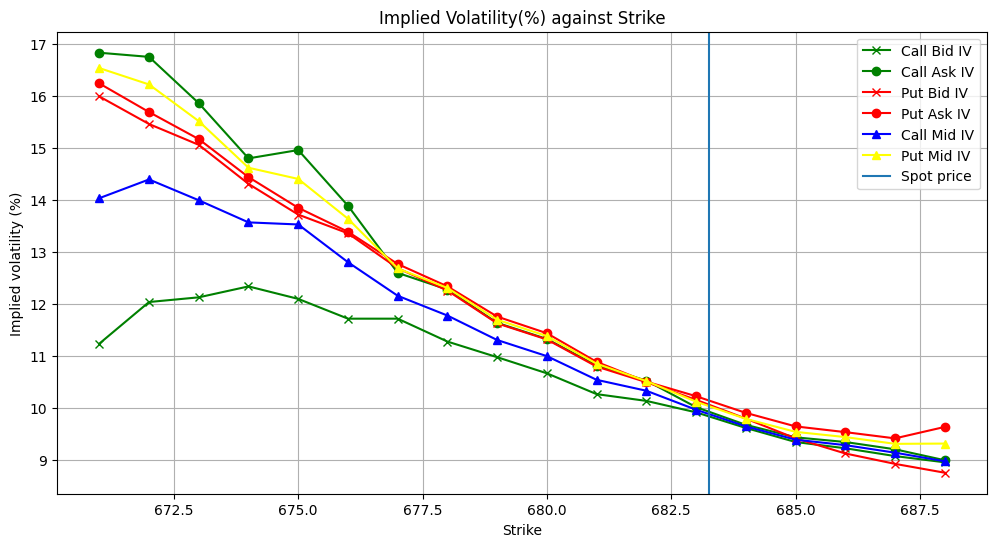

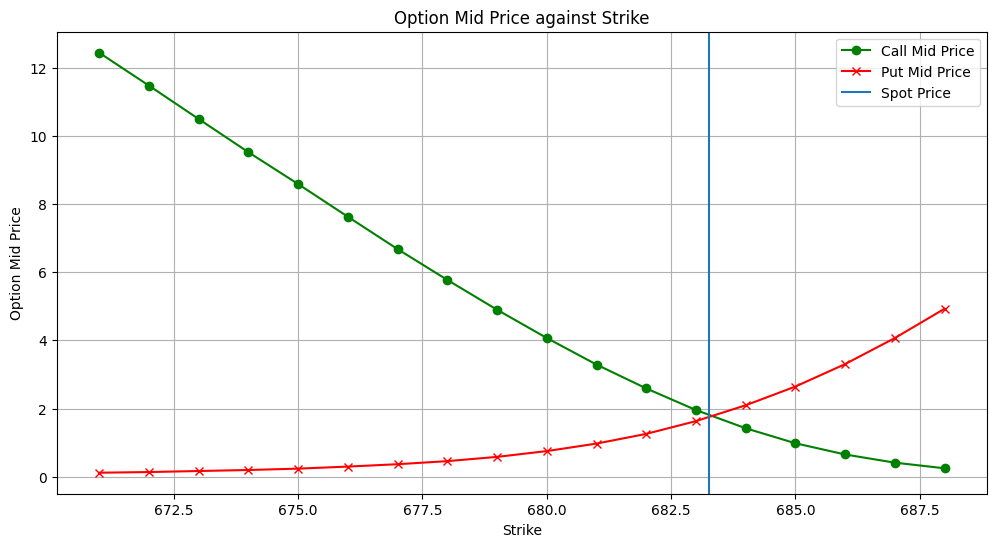

In [19]:
def plot_market_iv(df):
    fig = plt.figure(figsize = (12,6))
    plt.plot(df["Strike Price"], df["Call Bid IV"], color = 'green', marker = 'x', label = "Call Bid IV")
    plt.plot(df["Strike Price"], df["Call Ask IV"], color = "green", marker = "o", label = "Call Ask IV")
    plt.plot(df["Strike Price"], df["Put Bid IV"], color = "red", marker = "x", label = "Put Bid IV")
    plt.plot(df["Strike Price"], df["Put Ask IV"], color = "red", marker = "o", label = "Put Ask IV")
    plt.plot(df["Strike Price"], df["Call Mid IV"], color = "blue", marker = "^", label = "Call Mid IV")
    plt.plot(df["Strike Price"], df["Put Mid IV"], color = "yellow", marker = "^", label = "Put Mid IV")
    plt.axvline(x = S0, label = "Spot price")
    plt.xlabel("Strike")
    plt.ylabel("Implied volatility (%)")
    plt.title("Implied Volatility(%) against Strike")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_call_put_prices(df):
    fig = plt.figure(figsize = (12,6))
    plt.plot(df["Strike Price"], df["Call Mid Price"], color = 'green', marker = "o", label = "Call Mid Price")
    plt.plot(df["Strike Price"], df["Put Mid Price"], color = "red", marker = "x", label = "Put Mid Price")
    plt.axvline(x = S0, label = "Spot Price")
    plt.xlabel("Strike")
    plt.ylabel("Option Mid Price")
    plt.title("Option Mid Price against Strike")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_market_iv(df)
plot_call_put_prices(df)



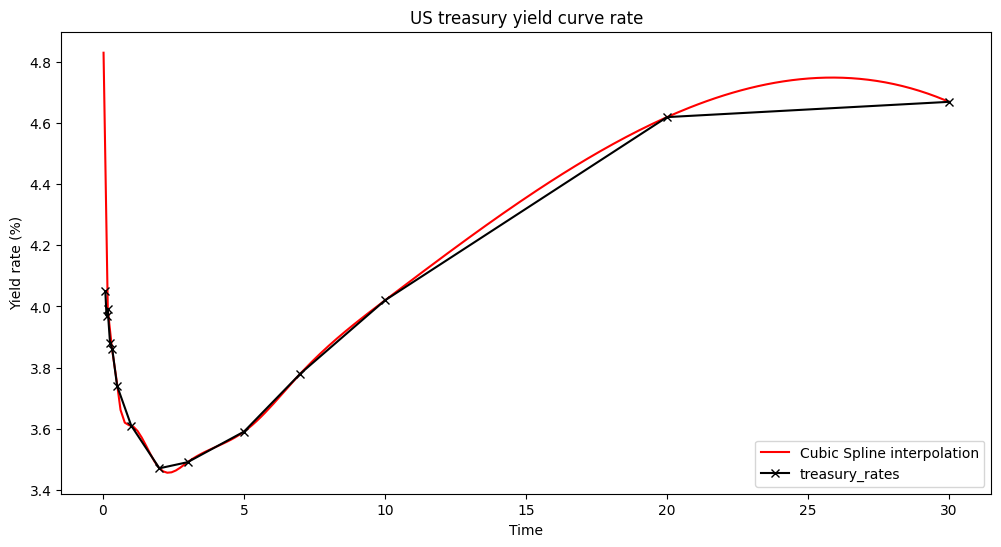

In [20]:
def time_to_expiry(todays_date:datetime, expiry_date:datetime):
    delta = expiry_date - todays_date
    return delta.seconds / (365 * 24 * 60 * 60)

us_treasury_yield_rates = pd.read_csv("daily-treasury-rates.csv")
us_treasury_yield_rates.head()

def extract_yield_curve(rates):
    rates = rates.values
    return rates[0][1:]

maturities = [0.083, 0.125, 0.167, 0.25, 0.33, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
us_treasury_yield_rates = extract_yield_curve(us_treasury_yield_rates)
cs = CubicSpline(maturities, us_treasury_yield_rates)
x_dense = np.linspace(0.02, 30.0, 200)
y_dense = cs(x_dense)
plt.figure(figsize = (12,6))
plt.plot(x_dense, y_dense, color = 'red', label = "Cubic Spline interpolation")
plt.plot(maturities, us_treasury_yield_rates, color = "black", marker = "x", label = "treasury_rates")

plt.xlabel("Time")
plt.ylabel("Yield rate (%)")
plt.title("US treasury yield curve rate")
plt.legend()
plt.show()


In [21]:
todays_date = datetime(2025, 11, 28, 12, 59)
expiry_date = datetime(2025, 12, 1, 16, 00)
T = time_to_expiry(todays_date, expiry_date)
r = cs(T)



In [ ]:
r = r/100.0 # turn to rate

# Calibration of SVJ surface
def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = SVJparams(kappa = x[0], sigma = x[1], theta = x[2], v0 = x[3], rho = x[4], lamda = x[5], mu_j = x[6], sigma_j = x[7])
        C_model = European_Call(SVJ_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(SVJ_cf_St, S0, K, T, r, 0.0, p)
        error += call_weight * (C_model - row["Call Mid Price"]) ** 2 + put_weight * (P_model - row["Put Mid Price"]) ** 2
    return error

# initial parameters guess
p0 = np.array([1.0,0.04,0.04,0.03,-0.32,0.06,-0.1,0.3])

bounds = [
    (1e-4, 10.0),    # kappa   ∈ (0, 10]
    (1e-4,  2.0),    # sigma   ∈ (0, 5]
    (1e-4,  1.0),    # theta   ∈ (0, 1]
    (1e-6,  1.0),    # v0      ∈ (0, 1]
    (-0.999, 0.999), # rho     ∈ (-0.999, 0.999)
    (0.0,   40.0),    # lamda   ∈ [0, 40]
    (-40.0,  40.0),    # mu_j    ∈ [-40.0, 40.0] (down jumps)
    (1e-4,  1.0),    # sigma_j ∈ (0, 1] 
]

svj_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

svj_x_opt = svj_res.x

In [23]:
# Calibration of Heston Surface

def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = HestonParams(kappa = x[0], sigma = x[1], theta = x[2], v0 = x[3], rho = x[4])
        C_model = European_Call(Heston_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(Heston_cf_St, S0, K, T, r, 0.0, p)
        error += call_weight * (C_model - row["Call Mid Price"]) ** 2 + put_weight * (P_model - row["Put Mid Price"]) ** 2
    return error

# initial parameters guess
p0 = np.array([1.0,0.04,0.04,0.03,-0.32])

bounds = [
    (1e-4, 10.0),    # kappa   ∈ (0, 10]
    (1e-4,  2.0),    # sigma   ∈ (0, 5]
    (1e-4,  1.0),    # theta   ∈ (0, 1]
    (1e-6,  1.0),    # v0      ∈ (0, 1]
    (-0.999, 0.999), # rho     ∈ (-0.999, 0.999)
]

heston_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

heston_x_opt = heston_res.x

In [24]:
# Calibration of Kou Model

def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = KouParams(lamda = x[0], sigma = x[1], prob = x[2], eta_plus = x[3], eta_minus = x[4])
        C_model = European_Call(Kou_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(Kou_cf_St, S0, K, T, r, 0.0, p)
        error += call_weight * (C_model - row["Call Mid Price"]) ** 2 + put_weight * (P_model - row["Put Mid Price"]) ** 2
    return error

# initial parameters guess
p0 = np.array([1.08,0.04,0.63,7.61,5.50])

bounds = [
    (1e-4, 10.0),    # lamda   ∈ (0, 10]
    (1e-4,  5.0),    # sigma   ∈ (0, 5]
    (1e-4,  1.0),    # prob   ∈ (0, 1]
    (1e-4,  40.0),    # eta_plus     ∈ (0, 40]
    (1e-4, 40.0), # eta_minus     ∈ (0, 40)
]

kou_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

kou_x_opt = kou_res.x

In [25]:
print(svj_x_opt)
print(heston_x_opt)
print(kou_x_opt)

[ 1.29705855  0.67921787  0.0716974   0.10793065 -0.51364798  1.27570666
 -1.48403802  0.16050391]
[ 8.65258716  2.          0.85572211  0.12872118 -0.999     ]
[1.00000000e+01 3.26674720e-01 1.00000000e-04 2.72637334e+01
 7.95799078e+00]


In [26]:
opt_SVJ_params = SVJparams(kappa = svj_x_opt[0],
                           sigma = svj_x_opt[1],
                           theta = svj_x_opt[2],
                           v0    = svj_x_opt[3],
                           rho   = svj_x_opt[4],
                           lamda = svj_x_opt[5],
                           mu_j = svj_x_opt[6],
                           sigma_j = svj_x_opt[7]
                                   )

opt_Heston_params = HestonParams(
                                kappa = heston_x_opt[0],
                                sigma = heston_x_opt[1],
                                theta = heston_x_opt[2],
                                v0 = heston_x_opt[3],
                                rho = heston_x_opt[4])

opt_Kou_params = KouParams(lamda= kou_x_opt[0],
                           sigma = kou_x_opt[1],
                           prob = kou_x_opt[2],
                           eta_plus=kou_x_opt[3],
                           eta_minus=kou_x_opt[4])


SVJ_calls = np.array([])
SVJ_puts = np.array([])
Heston_calls = np.array([])
Heston_puts = np.array([])
Kou_calls = np.array([])
Kou_puts = np.array([])

for strike in df["Strike Price"]:
    SVJ_calls = np.append(SVJ_calls,np.round(European_Call(SVJ_cf_St, S0, strike, T, r, 0.0, opt_SVJ_params),2))
    SVJ_puts = np.append(SVJ_puts, np.round(European_Put(SVJ_cf_St, S0, strike, T, r, 0.0, opt_SVJ_params),2))
    Heston_calls = np.append(Heston_calls,np.round(European_Call(Heston_cf_St, S0, strike, T, r, 0.0, opt_Heston_params),2))
    Heston_puts = np.append(Heston_puts,np.round(European_Put(Heston_cf_St, S0, strike, T, r, 0.0, opt_Heston_params),2))
    Kou_calls = np.append(Kou_calls,np.round(European_Call(Kou_cf_St, S0, strike, T, r, 0.0, opt_Kou_params),2))
    Kou_puts = np.append(Kou_puts,np.round(European_Put(Kou_cf_St, S0, strike, T, r, 0.0, opt_Kou_params),2))


df["SVJ call price"] = SVJ_calls
df["SVJ put price"] = SVJ_puts
df["Heston call price"] = Heston_calls
df["Heston put price"] = Heston_puts
df["Kou call price"] = Kou_calls
df["Kou put price"] = Kou_puts

df.head()
                     



,Call Volume,Call Bid IV,Call Bid Price,Call Ask IV,Call Ask Price,Strike Price,Put Volume,Put Bid IV,Put Bid Price,Put Ask IV,...,Call Mid Price,Put Mid Price,call_weight,put_weight,SVJ call price,SVJ put price,Heston call price,Heston put price,Kou call price,Kou put price
71,387,11.24,12.37,16.83,12.52,671,2382,15.99,0.11,16.24,...,12.445,0.115,2580.000000,238200.0,12.50,0.23,12.28,0.01,12.50,0.23
72,715,12.04,11.39,16.75,11.57,672,3523,15.46,0.13,15.69,...,11.480,0.135,3972.222222,352300.0,11.51,0.23,11.29,0.02,11.50,0.23
73,116,12.13,10.41,15.86,10.59,673,7229,15.06,0.16,15.17,...,10.500,0.165,644.444444,722900.0,10.51,0.24,10.30,0.03,10.51,0.24
74,294,12.34,9.45,14.80,9.60,674,5141,14.31,0.19,14.44,...,9.525,0.195,1960.000000,514100.0,9.52,0.25,9.32,0.05,9.52,0.25
75,852,12.10,8.49,14.96,8.69,675,17965,13.72,0.23,13.85,...,8.590,0.235,4260.000000,1796500.0,8.54,0.26,8.35,0.08,8.54,0.27


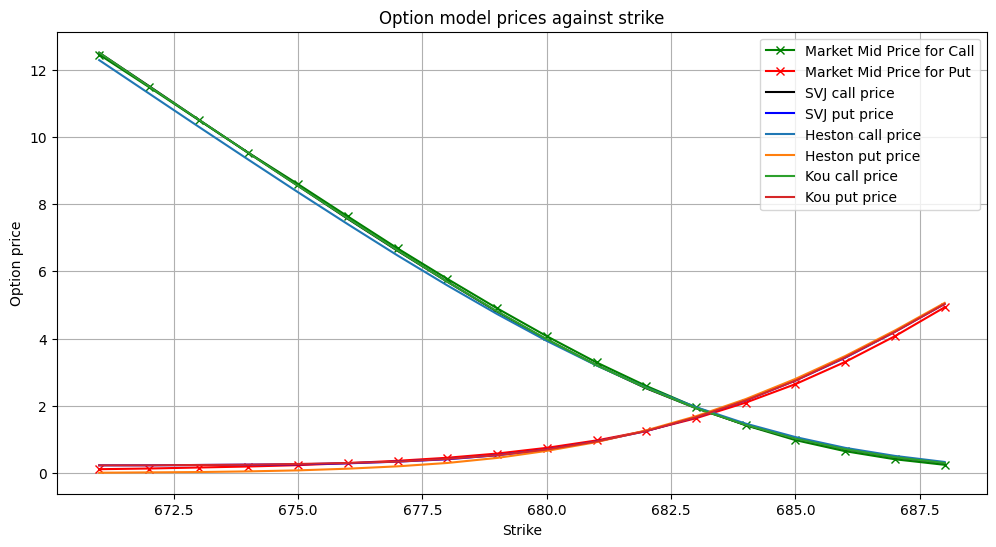

In [27]:
plt.figure(figsize=(12,6))
plt.plot(df["Strike Price"], df["Call Mid Price"], color = 'green', marker = "x", label = "Market Mid Price for Call")
plt.plot(df["Strike Price"], df["Put Mid Price"], color = 'red', marker = "x", label = "Market Mid Price for Put")
plt.plot(df["Strike Price"], df["SVJ call price"], color = 'black', label = "SVJ call price")
plt.plot(df["Strike Price"], df["SVJ put price"], color = 'blue', label = "SVJ put price")
plt.plot(df["Strike Price"], df["Heston call price"], label = "Heston call price")
plt.plot(df["Strike Price"], df["Heston put price"], label = "Heston put price")
plt.plot(df["Strike Price"], df["Kou call price"], label = "Kou call price")
plt.plot(df["Strike Price"], df["Kou put price"], label = "Kou put price")
plt.xlabel("Strike")
plt.ylabel("Option price")
plt.title("Option model prices against strike")
plt.grid(True)
plt.legend()

In [ ]:
# Overall MAPE
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["SVJ call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["SVJ put price"] / row["Put Mid Price"])) 
SVJ_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for SVJ: {SVJ_MAPE * 100:.2f} %")

Average Mean Absolute Percentage Error for SVJ: 12.18 %


In [ ]:
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["Heston call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["Heston put price"] / row["Put Mid Price"])) 
Heston_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for Heston: {Heston_MAPE * 100:.2f} %")

Average Mean Absolute Percentage Error for Heston: 11.28 %


In [ ]:
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["Kou call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["Kou put price"] / row["Put Mid Price"])) 
Kou_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for Kou: {Kou_MAPE * 100:.2f} %")

Average Mean Absolute Percentage Error for Kou: 12.19 %


# Model results

| Model | MAPE(%) | Calibration time(s)
|----------|----------|---------------|
| Heston   | 11.28 |  38.8    |
| SVJ      | 12.18 |  139.0   |
| Kou      | 12.19 |  57.9    |
